<font size="+3"><strong>Project: Bankruptcy in Taiwan 🇹🇼</strong></font>

### Introduction
In this project, we are going to create a model that predicts bankruptcy in Taiwan

In [3]:
# Import libraries here
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
import wqet_grader
from imblearn.over_sampling import RandomOverSampler
from IPython.display import VimeoVideo
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from teaching_tools.widgets import ConfusionMatrixWidget
from sklearn.base import ClassifierMixin
from sklearn.pipeline import Pipeline

# Prepare Data

## Import

Load the contents of the `"data/taiwan-bankruptcy-data.json.gz"` and assign it to the variable <code>taiwan_data</code>. 

Note that <code>taiwan_data</code> should be a dictionary. You'll create a DataFrame in a later task.

In [4]:
# Load data file
with gzip.open("data/taiwan-bankruptcy-data.json.gz", "r") as data_file:
    taiwan_data = json.load(data_file)


print(type(taiwan_data))

<class 'dict'>


Extract the key names from <code>taiwan_data</code> and assign them to the variable <code>taiwan_data_keys</code>.

In [5]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

dict_keys(['schema', 'metadata', 'observations'])


Calculate how many companies are in `taiwan_data` and assign the result to `n_companies`. 

In [6]:
n_companies = len(taiwan_data["observations"])
print(n_companies)

6137


Calculate the number of features associated with each company and assign the result to `n_features`.

In [7]:
n_features = taiwan_data["observations"][1]
print(n_features)

{'id': 2, 'bankrupt': True, 'feat_1': 0.4642909375, 'feat_2': 0.53821413, 'feat_3': 0.5167300177, 'feat_4': 0.6102350855, 'feat_5': 0.6102350855, 'feat_6': 0.9989459782, 'feat_7': 0.7973801913, 'feat_8': 0.8093007257, 'feat_9': 0.3035564303, 'feat_10': 0.7815059743, 'feat_11': 0.0002897851, 'feat_12': 0.0, 'feat_13': 0.4618672572, 'feat_14': 0.0006470647, 'feat_15': 0.0, 'feat_16': 0.182251064, 'feat_17': 0.182251064, 'feat_18': 0.182251064, 'feat_19': 0.208943935, 'feat_20': 0.3181368041, 'feat_21': 0.021144335, 'feat_22': 0.0937220096, 'feat_23': 0.1699179031, 'feat_24': 0.0220801699, 'feat_25': 0.8480878838, 'feat_26': 0.6896929012, 'feat_27': 0.6897017016, 'feat_28': 0.2176195965, 'feat_29': 6110000000.0, 'feat_30': 0.0004430401, 'feat_31': 0.2645157781, 'feat_32': 0.376709139, 'feat_33': 0.0060162059, 'feat_34': 0.0040393668, 'feat_35': 0.6351724634, 'feat_36': 0.0125023938, 'feat_37': 0.1711763461, 'feat_38': 0.8288236539, 'feat_39': 0.0050588818, 'feat_40': 0.37676002, 'feat_41'

Create a `wrangle` function that takes as input the path of a compressed JSON file and returns the file's contents as a DataFrame. Be sure that the index of the DataFrame contains the ID of the companies. When your function is complete, use it to load the data into the DataFrame `df`.

In [8]:
# Create wrangle function
def wrangle(filename):
    #open compressed file and load into memory
    with gzip.open(filename, "r") as f:
        data = json.load(f)
    
    df = pd.DataFrame.from_dict(data["observations"]).set_index("id")
    
    
    return df

In [9]:
df =wrangle("data/taiwan-bankruptcy-data.json.gz")
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Explore

Is there any missing data in the dataset? Create a Series where the index contains the name of the columns in `df` and the values are the number of <code>NaN</code>s in each column. Assign the result to <code>nans_by_col</code>. Neither the Series itself nor its index require a name. 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6137 entries, 1 to 6819
Data columns (total 96 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bankrupt  6137 non-null   bool   
 1   feat_1    6137 non-null   float64
 2   feat_2    6137 non-null   float64
 3   feat_3    6137 non-null   float64
 4   feat_4    6137 non-null   float64
 5   feat_5    6137 non-null   float64
 6   feat_6    6137 non-null   float64
 7   feat_7    6137 non-null   float64
 8   feat_8    6137 non-null   float64
 9   feat_9    6137 non-null   float64
 10  feat_10   6137 non-null   float64
 11  feat_11   6137 non-null   float64
 12  feat_12   6137 non-null   float64
 13  feat_13   6137 non-null   float64
 14  feat_14   6137 non-null   float64
 15  feat_15   6137 non-null   float64
 16  feat_16   6137 non-null   float64
 17  feat_17   6137 non-null   float64
 18  feat_18   6137 non-null   float64
 19  feat_19   6137 non-null   float64
 20  feat_20   6137 non-null   floa

In [11]:
nans_by_col = pd.Series((df.isnull().sum()), index = df.columns)
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


bankrupt    0
feat_1      0
feat_2      0
feat_3      0
feat_4      0
dtype: int64

Is the data imbalanced? Create a bar chart that shows the normalized value counts for the column `df["bankrupt"]`. Be sure to label your x-axis `"Bankrupt"`, your y-axis `"Frequency"`, and use the title `"Class Balance"`.

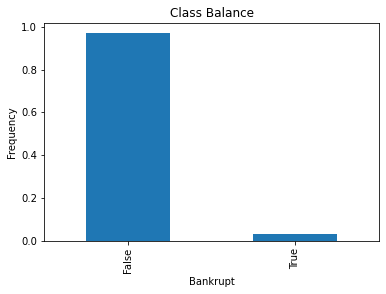

In [12]:
# Plot class balance
df["bankrupt"].value_counts(normalize = True).plot(
    kind = "bar",
    xlabel = "Bankrupt",
    ylabel = "Frequency",
    title = "Class Balance"
);

## Split

Create your feature matrix `X` and target vector `y`. Your target is `"bankrupt"`. 

In [14]:
target = "bankrupt"
X = df.drop(columns = [target])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


Divide your dataset into training and test sets using a randomized split. Your test set should be 20% of your data. We will set `random_state` to `42`.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_train.shape)
print("y_test shape:", y_train.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (4909, 95)
y_test shape: (4909,)


## Resample

Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data. Be sure to set the `random_state` to `42`.

In [16]:
over_sampler = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (9512, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.535855,0.599160,0.594411,0.627099,0.627099,0.999220,0.797686,0.809591,0.303518,0.781865,...,0.834091,0.022025,0.624364,0.627101,0.841977,0.275384,0.026791,0.565158,1,0.147943
1,0.554136,0.612734,0.595000,0.607388,0.607388,0.999120,0.797614,0.809483,0.303600,0.781754,...,0.840293,0.002407,0.624548,0.607385,0.842645,0.276532,0.026791,0.565158,1,0.062544
2,0.549554,0.603467,0.599122,0.620166,0.620166,0.999119,0.797569,0.809470,0.303524,0.781740,...,0.840403,0.000840,0.624010,0.620163,0.842873,0.277249,0.026800,0.565200,1,0.047929
3,0.543801,0.603249,0.606992,0.622515,0.622515,0.999259,0.797728,0.809649,0.303510,0.781930,...,0.831514,0.006176,0.626775,0.622513,0.842989,0.280013,0.026839,0.565375,1,0.028386
4,0.498659,0.562364,0.546978,0.603670,0.603670,0.998904,0.797584,0.809459,0.304000,0.781713,...,0.811988,0.004256,0.623674,0.603669,0.841105,0.277628,0.026897,0.565618,1,0.043080


# Build Model

## Iterate

Create a classifier <code>clf</code> that can be trained on `(X_train_over, y_train_over)`. You can use any of the predictors you've learned about in the Data Science Lab. 

In [17]:
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier())

Perform cross-validation with your classifier using the over-sampled training data, and assign your results to <code>cv_scores</code>. Be sure to set the <code>cv</code> argument to 5. 

In [18]:
cv_scores = cross_val_score(clf, X_train_over, y_train_over, cv = 5, n_jobs = -1)
print(cv_scores)

[0.96952181 0.97162375 0.96950578 0.97160883 0.96845426]


Create a dictionary <code>params</code> with the range of hyperparameters that you want to evaluate for your classifier.

In [19]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

Create a <code>GridSearchCV</code> named `model` that includes your classifier and hyperparameter grid. Be sure to set `cv` to 5, `n_jobs` to -1, and `verbose` to 1. 

In [20]:
model =  GridSearchCV(
    clf,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Fit model to the over-sampled training data. 

In [22]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Extract the cross-validation results from your model, and load them into a DataFrame named <code>cv_results</code>. Looking at the results, which set of hyperparameters led to the best performance?

In [23]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.174273,0.039548,0.005576,0.000112,2,20,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.909616,0.897530,0.903260,0.905363,0.906414,0.904437,0.004017,17
1,4.308223,0.052475,0.017838,0.024269,2,20,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.909616,0.897530,0.903260,0.905363,0.906414,0.904437,0.004017,17
2,5.191271,0.007465,0.005630,0.000251,2,25,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.912769,0.913820,0.917455,0.913775,0.912198,0.914004,0.001832,15
3,5.357866,0.047035,0.005655,0.000101,2,25,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.912769,0.913820,0.917455,0.913775,0.912198,0.914004,0.001832,15
4,6.218677,0.041074,0.005989,0.000313,2,30,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.923279,0.917499,0.916930,0.923239,0.919558,0.920101,0.002723,13


Extract the best hyperparameters from your model and assign them to <code>best_params</code>. 

In [25]:
best_params = model.best_params_
print(best_params)

{'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 30, 'simpleimputer__strategy': 'mean'}


## Evaluate

Test the quality of your model by calculating accuracy scores for the training and test data.

In [27]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.9708
Model Test Accuracy: 0.934


Plot a confusion matrix that shows how your model performed on your test set.

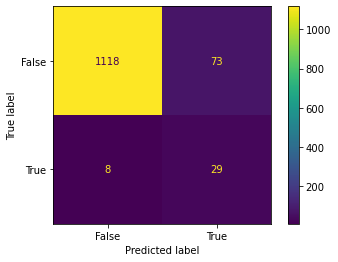

In [28]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

Generate a classification report for your model's performance on the test data and assign it to `class_report`.

In [30]:
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.99      0.94      0.97      1191
        True       0.28      0.78      0.42        37

    accuracy                           0.93      1228
   macro avg       0.64      0.86      0.69      1228
weighted avg       0.97      0.93      0.95      1228



# Communicate

Create a horizontal bar chart with the 10 most important features for your model. Be sure to label the x-axis `"Gini Importance"`, the y-axis `"Feature"`, and use the title `"Feature Importance"`.

In [34]:
model.best_estimator_.named_steps

{'simpleimputer': SimpleImputer(),
 'gradientboostingclassifier': GradientBoostingClassifier(max_depth=4, n_estimators=30)}

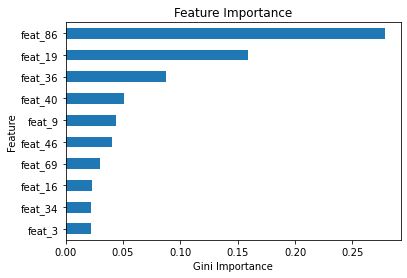

In [35]:
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["gradientboostingclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index = features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");
# Don't delete the code below 👇
plt.savefig("images/5-5-17.png", dpi=150)


Save your best-performing model to a a file named <code>"model-5-5.pkl"</code>.

In [37]:
# Save model
with open("model-5-5.pkl", "wb") as f:
    pickle.dump(model, f)

Open the file <code>my_predictor_assignment.py</code>. Add your `wrangle` function, and then create a `make_predictions` function that takes two arguments: `data_filepath` and <code>model_filepath</code>. Use the cell below to test your module. When you're satisfied with the result, submit it to the grader. 

In [39]:
# Import your module
from my_predictor_assignment import wrangle, make_predictions

# Generate predictions
y_test_pred = make_predictions(
    data_filepath="data/taiwan-bankruptcy-data-test-features.json.gz",
    model_filepath="model-5-5.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


id
18    False
20    False
24     True
32     True
38    False
Name: bankrupt, dtype: bool